# Programming your own convolutional network

Today's lab will use a common dataset called [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to let us practice making a convolutional neural network for classification.  This dataset consists of 60,000 32x32 color pictures, each of which map to one of ten classes.  To do this, we'll use Pytorch's built-in CIFAR10 Dataset, so we won't need to program our own.

The two cells below handle imports, and then build the training and testing Datasets.  The first time you run these, it will actually download the data for you.  Notice there are some transformations listed - you're welcome to add to these (and perhaps should), but you'll need at least these, which turn the image file into a Pytorch Image, and then convert them to 32-bit floats.

The end of the second cell prints out the labels, just so we can see it's working.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [2]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
trainSet = CIFAR10('.', train=True, transform=train_transforms, download=True)
testSet = CIFAR10('.', train=False, transform=test_transforms)
actuallabels = trainSet.classes
print('Labels are: ',actuallabels)

Files already downloaded and verified
Labels are:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


OK!  Let's make sure that our Datasets are working.  Below I access the first element of the training set, which will give a tuple of the image and the first label (encoded as an integer, which is an index to the class list above).  I then display the first image - we should make sure the label and the image match.

Label is index 6, with semantic name frog


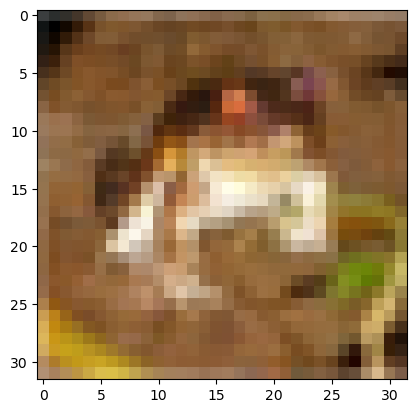

In [3]:
import matplotlib.pyplot as plt
firstimg, firstlabel = trainSet[0]
print(f'Label is index {firstlabel}, with semantic name {actuallabels[firstlabel]}')
plt.imshow(firstimg.permute(1, 2, 0))

Should look OK (though the image is displayed too large, perhaps).  Let's do the same thing with the first testing image.

Label is index 3, with semantic name cat


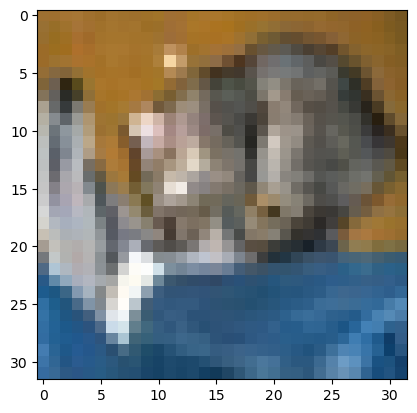

In [4]:
secimg, seclabel = testSet[0]
print(f'Label is index {seclabel}, with semantic name {actuallabels[seclabel]}')
plt.imshow(secimg.permute(1, 2, 0))

Now we build a DataLoader, which will handle pulling out batches for training and testing.

In [5]:
trainLoader = DataLoader(trainSet, batch_size=100, shuffle=True, num_workers=4)
testLoader = DataLoader(testSet, batch_size=100, shuffle=False, num_workers=4)

You now should have everything you need to start performing your classification.  Build yourself a convolutional network, and train it to do as well as you can (on the test set, of course).  Create a function which measures accuracy, so you can say how well your model is doing.

Remember that you can save models, so that you don't have to retrain every time you pick this lab back up again.

You may not use generative AI on this portion of the lab.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.do = nn.Dropout(.5)
        self.out = nn.Linear(4096, 1000)
        self.out_act = nn.ReLU()
        self.out2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.do(x)
        x = self.out(x)
        x = self.out_act(x)
        output = self.out2(x)
        return output

In [ ]:
#import time
from tqdm import tqdm

model = CNN().to('cuda')

EPOCHS = 500

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)
for epoch in tqdm(range(EPOCHS)):
    totalloss = 0
    for batch, (X, y) in enumerate(trainLoader):
        X = X.to('cuda')
        y = torch.Tensor(y).to('cuda')
        predictions = model(X)
        loss = criterion(predictions, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalloss += loss.item()

    if epoch % 20 == 0:
        totalloss /= len(trainLoader)
        print('Loss/train', totalloss, epoch)
        test_loss = 0

        with torch.no_grad():
            for X, y in testLoader:
                X = X.to('cuda')
                y = torch.Tensor(y).to('cuda')
                pred = model(X)
                test_loss += criterion(pred, y).item()
            test_loss /= len(testLoader)
        print('Loss/test', test_loss, epoch)

  0%|                                                   | 0/500 [00:00<?, ?it/s]

Loss/train 2.41909734582901 0


  0%|                                           | 1/500 [00:02<20:00,  2.41s/it]

Loss/test 2.3029458141326904 0


  4%|█▋                                        | 20/500 [00:34<13:26,  1.68s/it]

Loss/train 2.303464484214783 20


  4%|█▊                                        | 21/500 [00:36<14:32,  1.82s/it]

Loss/test 2.302732036113739 20


  8%|███▎                                      | 40/500 [01:08<12:58,  1.69s/it]

Loss/train 2.3032781090736387 40


  8%|███▍                                      | 41/500 [01:10<14:06,  1.84s/it]

Loss/test 2.3034538555145265 40


 12%|█████                                     | 60/500 [01:43<12:44,  1.74s/it]

Loss/train 2.3034332165718077 60


 12%|█████                                     | 61/500 [01:45<13:38,  1.86s/it]

Loss/test 2.3028664493560793 60


 16%|██████▋                                   | 80/500 [02:18<12:23,  1.77s/it]

Loss/train 2.303256652355194 80


 16%|██████▊                                   | 81/500 [02:20<13:15,  1.90s/it]

Loss/test 2.303295364379883 80


 20%|████████▏                                | 100/500 [02:52<11:13,  1.68s/it]

Loss/train 2.30338258600235 100


 20%|████████▎                                | 101/500 [02:55<12:12,  1.84s/it]

Loss/test 2.303395218849182 100


 24%|█████████▊                               | 120/500 [03:27<10:56,  1.73s/it]

Loss/train 2.303342332363129 120


 24%|█████████▉                               | 121/500 [03:29<11:38,  1.84s/it]

Loss/test 2.3030657839775084 120


 28%|███████████▍                             | 140/500 [04:01<10:12,  1.70s/it]

Loss/train 2.3035301241874695 140


 28%|███████████▌                             | 141/500 [04:04<10:59,  1.84s/it]

Loss/test 2.302893831729889 140


 32%|█████████████                            | 160/500 [04:37<10:00,  1.77s/it]

Loss/train 2.3035045051574707 160


 32%|█████████████▏                           | 161/500 [04:39<10:40,  1.89s/it]

Loss/test 2.3033479952812197 160


 33%|█████████████▌                           | 166/500 [04:47<09:49,  1.76s/it]

In [ ]:
from sklearn.metrics import confusion_matrix
def build_confusion(predictions,truth,title):
    cm=confusion_matrix(predictions,truth)
    import plotly.graph_objects as go
    # Create a Plotly heatmap
    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=[f'Predicted {i}' for i in range(cm.shape[0])],
        y=[f'Actual {i}' for i in range(cm.shape[0])],
        colorscale='Viridis',  # You can choose any colorscale you like
        colorbar=dict(title='Count')
    ))
    
    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title='Predicted label',
        yaxis_title='Actual label',
    )
    
    # Show plot
    fig.show()

In [ ]:
with torch.no_grad():
    numright=0
    for batch, (X,y) in enumerate(trainLoader):
        X=X.to('cuda')
        preds=np.argmax(model(X).detach().cpu().numpy(),axis=1)
        truth=y.numpy()
        numright+=sum(preds==truth)
    print(f'Accuracy on training set is {numright/len(trainLoader)}')

In [ ]:
with torch.no_grad():
    numright=0
    for batch, (X,y) in enumerate(testLoader):
        X=X.to('cuda')
        preds=np.argmax(model(X).detach().cpu().numpy(),axis=1)
        truth=y.numpy()
        numright+=sum(preds==truth)
    print(f'Accuracy on testing set is {numright/len(trainLoader)}')